In [3]:
!pip install pmdarima

     |████████████████████████████████| 595 kB 2.7 MB/s eta 0:00:01


In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('/Users/kellywang/Downloads/AAPL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-16,118.919998,120.989998,118.150002,120.300003,119.562920,91183000
2020-11-17,119.550003,120.669998,118.959999,119.389999,118.658493,74271000
2020-11-18,118.610001,119.820000,118.000000,118.029999,117.306831,76322100
2020-11-19,117.589996,119.059998,116.809998,118.639999,117.913086,74113000
2020-11-20,118.639999,118.769997,117.290001,117.339996,116.621056,73604300
...,...,...,...,...,...,...
2021-11-08,151.410004,151.570007,150.160004,150.440002,150.440002,55020900
2021-11-09,150.199997,151.429993,150.059998,150.809998,150.809998,56787900
2021-11-10,150.020004,150.130005,147.850006,147.919998,147.919998,65187100


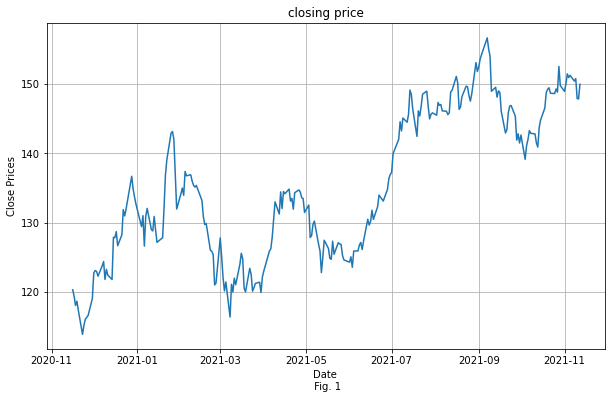

In [178]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date \n Fig. 1')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('closing price')
plt.show()

<AxesSubplot:xlabel='Fig. 2', ylabel='Density'>

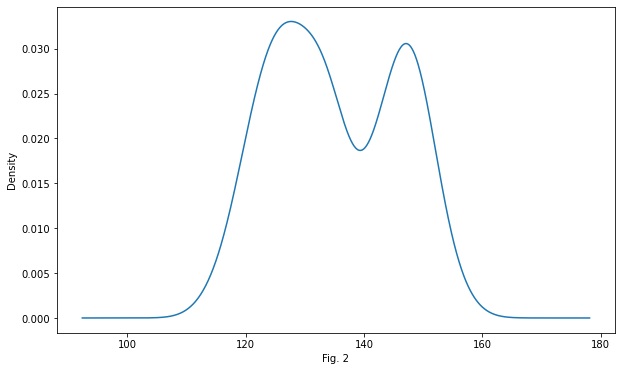

In [180]:
#Distribution of the dataset
df_close = stock_data['Close']
plt.xlabel('Fig. 2')
df_close.plot(kind='kde')

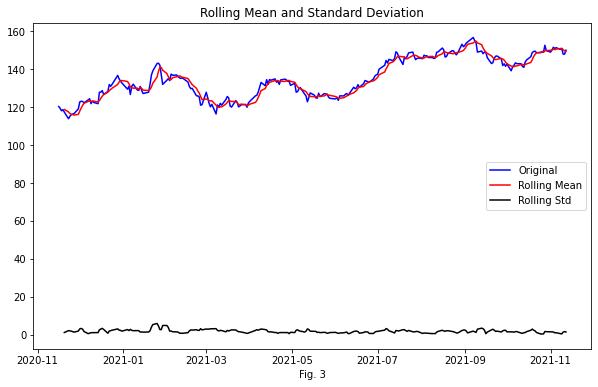

Results of dickey fuller test
Test Statistics                 -1.544322
p-value                          0.511483
No. of lags used                 0.000000
Number of observations used    250.000000
critical value (1%)             -3.456781
critical value (5%)             -2.873172
critical value (10%)            -2.572969
dtype: float64


In [181]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(5).mean()
    rolstd = timeseries.rolling(5).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Fig. 3')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

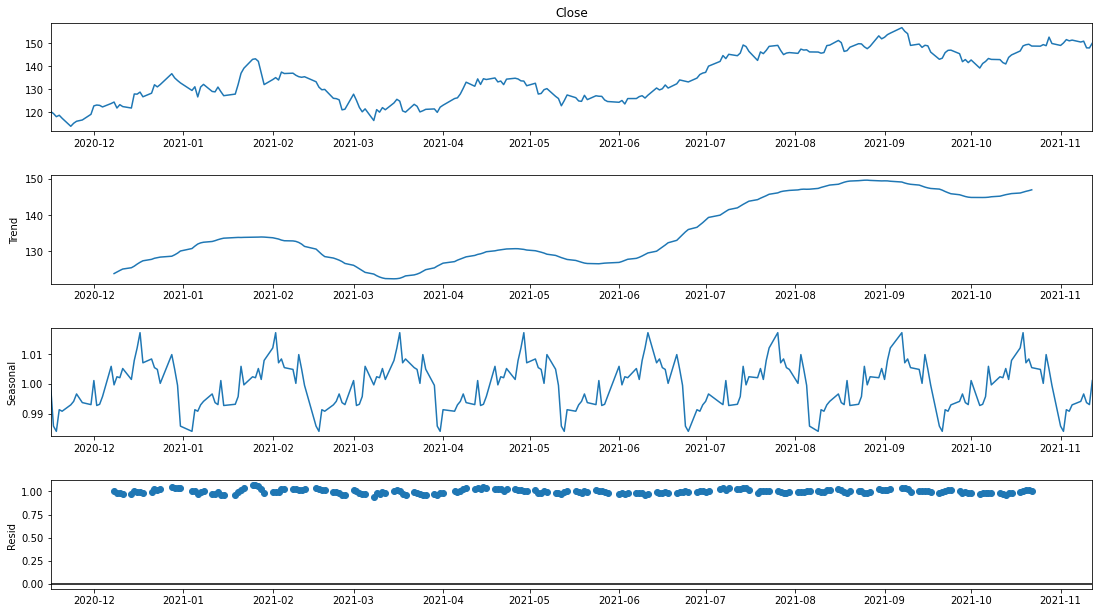

In [183]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


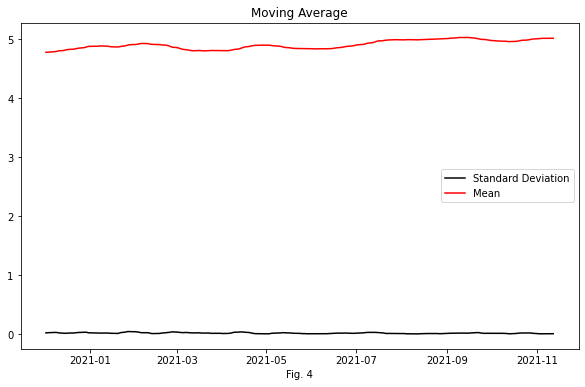

In [184]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.xlabel('Fig. 4')
plt.legend()
plt.show()

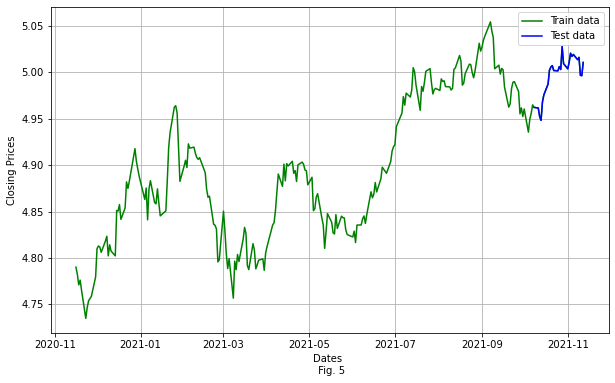

In [186]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates \n Fig. 5')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1192.261, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1190.745, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1190.773, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1193.645, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1188.544, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.230 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 597.822
Date:                Mon, 15 Nov 2021   AIC                          -1193.645
Time:                        10:33:41   BIC                          -1190.246
Sample:                             0   HQIC                         -1192.272
                                - 222                                  

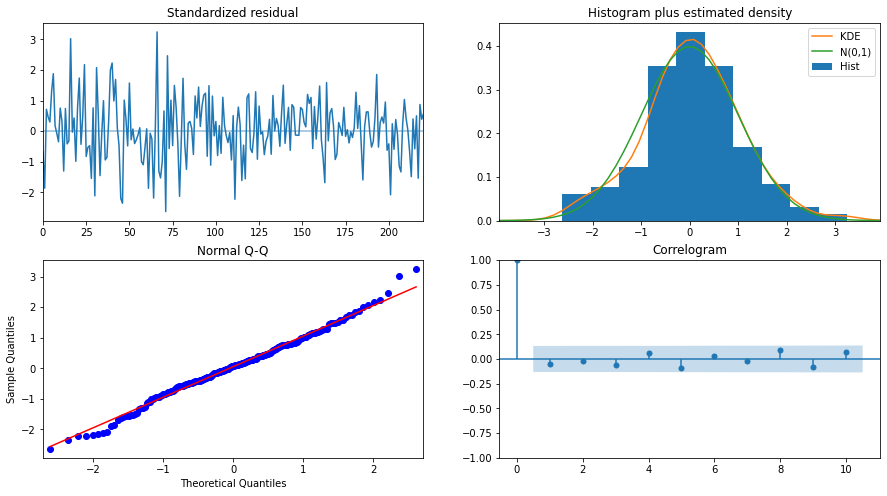

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [168]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 598.131
Method:                           css   S.D. of innovations              0.016
Date:                Tue, 16 Nov 2021   AIC                          -1192.261
Time:                        09:17:33   BIC                          -1185.465
Sample:                             1   HQIC                         -1189.517
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.786      0.432      -0.001       0.003


/Users/kellywang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/kellywang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [164]:
# Forecast
fc, se, conf = fitted.forecast(26, alpha=0.05)  # 95% conf

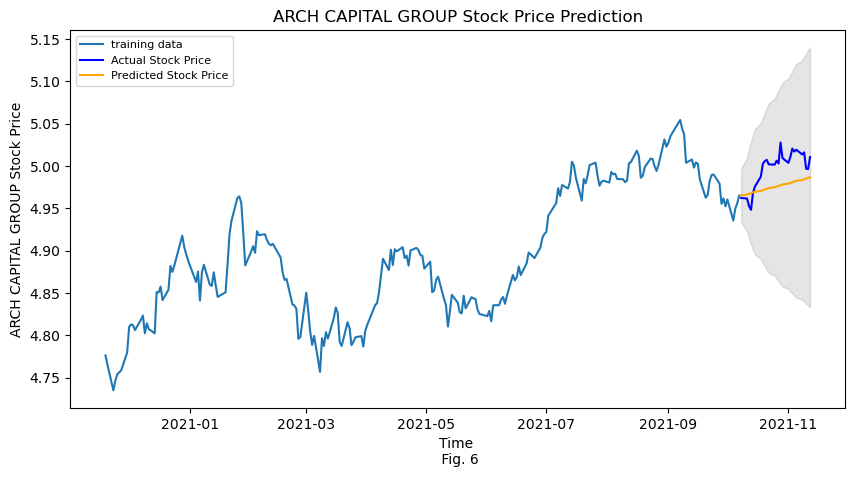

In [188]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time \n Fig. 6')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [166]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(2,2,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  220
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 559.035
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 16 Nov 2021   AIC                          -1110.071
Time:                        09:01:28   BIC                          -1096.496
Sample:                             2   HQIC                         -1104.589
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0001      0.001      0.161      0.872      -0.001       0.001
ar.L1.D2.Close    -0.6746      0.064    -10.571      0.000      -0.800      -0.550
ar.L2.D2.Close    -0.3159      0.064

/Users/kellywang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/kellywang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [167]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.000744987300385414
MAE: 0.024375593205961447
RMSE: 0.027294455487981695
MAPE: 0.004869354383625137
